In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
import numpy as np
from scipy.sparse import identity
from scipy.sparse.linalg import inv
from torch_geometric.utils import to_scipy_sparse_matrix
from model.utils import create_hetero_data
from torch_geometric.utils import subgraph
import torch
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

In [2]:
data_name = 'amlsim_mixed'
ext_rate = 0.4
data_path = f'hetero_data/{data_name}/ext_{ext_rate}/'
data = create_hetero_data(data_path)
# homo_data = data.to_homogeneous()

In [3]:
uniform_pred = np.load(f'outputs/{data_name}/baseline_hetero_SAGE_ext_{ext_rate}.npz')
qb_pred = np.load(f'outputs/{data_name}/baseline_hetero_SAGE-SMOTE_ext_{ext_rate}.npz')

In [4]:
def label_confusion_matrix_elements(pred_labels, true_labels):
    """
    Label each prediction as TP, TN, FP, or FN based on the predicted and true labels.

    Args:
        pred_labels (torch.Tensor): Predicted labels.
        true_labels (torch.Tensor): True labels.

    Returns:
        list: A list of strings with labels 'TP', 'TN', 'FP', or 'FN' for each prediction.
    """
    assert pred_labels.shape == true_labels.shape, "Shape of predicted and true labels must be the same"

    labels = []
    for pred, true in zip(pred_labels, true_labels):
        if pred == 1 and true == 1:
            labels.append('TP')
        elif pred == 0 and true == 1:
            labels.append('FN')
        elif pred == 0 and true == 0:
            labels.append('TN')
        elif pred == 1 and true == 0:
            labels.append('FP')

    return np.array(labels)

conf_labels_uniform = label_confusion_matrix_elements(uniform_pred['pred_scores'].argmax(axis=1),
                                                        uniform_pred['true'])
conf_labels_qb = label_confusion_matrix_elements(qb_pred['pred_scores'].argmax(axis=1),
                                                    qb_pred['true'])
assert len(conf_labels_qb) == len(data['internal'].y)
assert len(conf_labels_uniform) == len(data['internal'].y)

In [5]:
# Assign the internal nodes with the confusion labels for both uniform and qb
data['internal'].conf_labels_uniform = conf_labels_uniform
data['internal'].conf_labels_qb = conf_labels_qb

In [6]:
data['internal'].conf_labels_uniform = conf_labels_uniform

# # Convert PyTorch Geometric graph to NetworkX graph
# def to_networkx(data):
#     G = nx.Graph()
#     edge_index = data['internal', 'internal_txn', 'internal'].edge_index
#     edges = edge_index.t().tolist()
#     G.add_edges_from(edges)
#     return G

# G = to_networkx(data)

# # Get coordinates using star_layout
# pos = nx.drawing.spectral_layout(G)

features = data['internal'].x
tsne = TSNE(n_components=2, random_state=42)
coords = tsne.fit_transform(features)

# Convert positions to a numpy array for visualization
# coords = np.array([pos[i] for i in pos.keys()])



In [7]:
# Visualize the point scatter
    # Create a color map for the different labels
color_map = {'TP': 'green', 'TN': 'blue', 'FP': 'red', 'FN': 'orange'}
size_map = {'TP': 50, 'TN': 10, 'FP': 10, 'FN': 50}
marker_map = {'TP': 'o', 'TN': 'o', 'FP': 'x', 'FN': 'x'}

colors = np.array([color_map[label] for label in conf_labels_uniform])
sizes = np.array([size_map[label] for label in conf_labels_uniform])
markers = np.array([marker_map[label] for label in conf_labels_uniform])

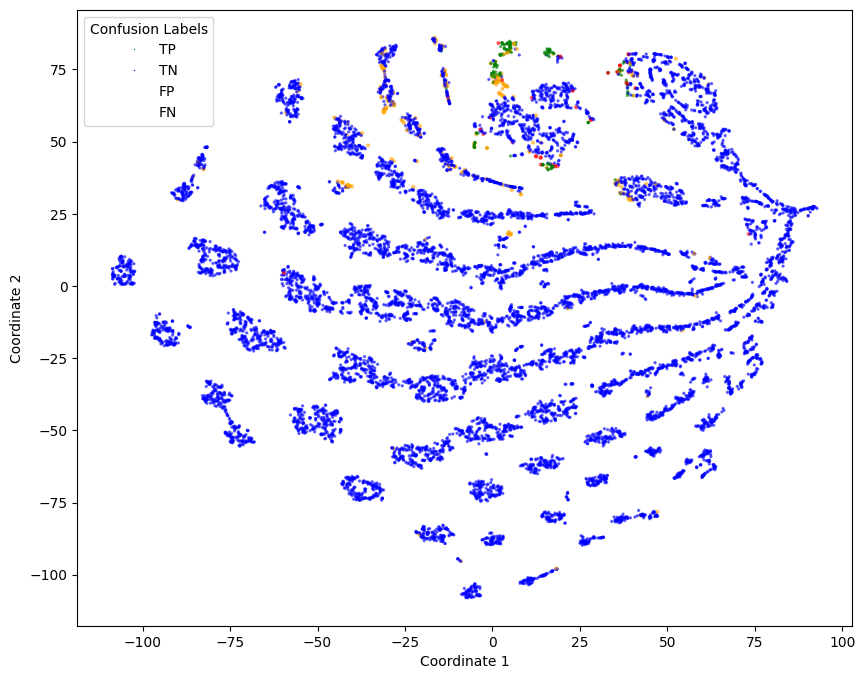

In [15]:

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c=colors, label=conf_labels_uniform,
            s=sizes, marker='o',alpha=0.5)

# Create a legend for the labels
handles = [plt.Line2D([0], [0], marker=marker_map[conf_value],
                      color='w', markerfacecolor=color_map[conf_value],
                      markersize=size_map[conf_value]) 
            for conf_value in color_map.keys()]
plt.legend(handles, color_map.keys(), title='Confusion Labels')

plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
plt.show()

In [19]:
# # Compute the degree matrix
# D = np.array(A.sum(axis=1)).flatten()
# D_inv_sqrt = np.zeros_like(D)
# nonzero_indices = D != 0
# D_inv_sqrt[nonzero_indices] = 1.0 / np.sqrt(D[nonzero_indices])
# D_inv_sqrt = np.diag(D_inv_sqrt)

# # Compute the normalized adjacency matrix
# A_prime = D_inv_sqrt @ A @ D_inv_sqrt


# Randomly sample the index, the labels are imbalanced

In [8]:
np.random.seed(42)
sample_size = 2000
sample_idx = np.random.choice(np.arange(len(coords)), sample_size, replace=False)
X = coords[sample_idx]

# Calculate the label propagation
G = to_networkx(data, node_attrs=['x'])
# Get the adjacency matrix
A = nx.adjacency_matrix(G).todense()
A = A[sample_idx, :][:, sample_idx]

<Figure size 1000x800 with 0 Axes>

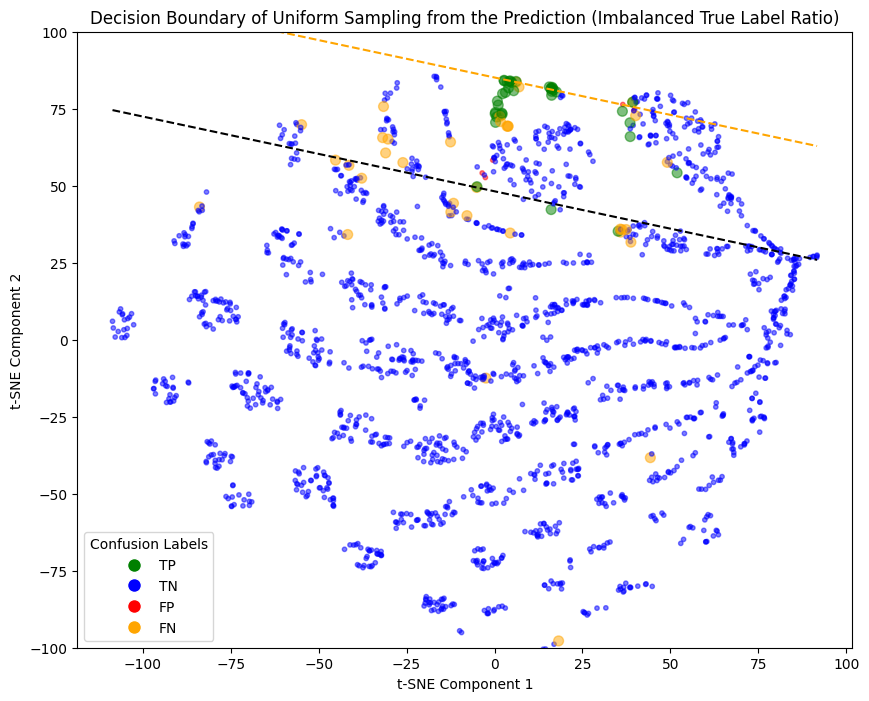

In [9]:
# Plot the decision boundary as a line, choose the 50-50 case
plt.figure(figsize=(10, 8))
a = np.abs(1 - uniform_pred['pred_scores'][sample_idx,1]/uniform_pred['pred_scores'][sample_idx,0])
x_values = X[a.argsort()[:2],0]
y_values = X[a.argsort()[:2],1]

# Calculate the slope
slope1 = (y_values[1] - y_values[0]) / (x_values[1] - x_values[0])

# Define the x-limits of the plot
x_min, x_max = X[:, 0].min(), X[:, 0].max()

# Calculate the y-values at the x-limits
y_min = slope1 * (x_min - x_values[0]) + y_values[0]
y_max = slope1 * (x_max - x_values[0]) + y_values[0]

# Node influence boundary
A_prime = A.copy()
# Parameters
alpha = 0.85  # random walk restart probability
I = np.eye(A_prime.shape[0])

# Initial label distribution (one-hot vectors for labeled nodes)
Y0 = np.zeros((A.shape[0], 2))
Y0[:, 1] = uniform_pred['pred_scores'][sample_idx, 1]
Y0[:, 0] = 1 - Y0[:, 1]
# Label propagation
Y_prop = alpha * np.linalg.inv(I - (1 - alpha) * A_prime) @ Y0

b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])
x_values_inf = X[b.argsort()[3],0]
y_values_inf = X[b.argsort()[3],1]
# slope_inf = (y_values_inf[1] - y_values_inf[0]) / (x_values_inf[1] - x_values_inf[0])
y_min_inf = slope1 * (x_min - x_values_inf) + y_values_inf
y_max_inf = slope1 * (x_max - x_values_inf) + y_values_inf

plt.figure(figsize=(10, 8))
# Plot the line for the decision boundary
plt.plot([x_min, x_max], [y_min, y_max], 'k--',label='Classification Boundary')
plt.plot([x_min, x_max], [y_min_inf, y_max_inf], '--',color='orange',label='Influence Boundary')

plt.scatter(coords[sample_idx, 0], coords[sample_idx, 1], c=colors[sample_idx], 
            label=conf_labels_uniform[sample_idx],
            s=sizes[sample_idx], marker='o',
            alpha=0.5)

# Create a legend for the labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
            for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Confusion Labels')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Decision Boundary of Uniform Sampling from the Prediction (Imbalanced True Label Ratio)')
plt.ylim(-100, 100)
plt.show()

/tmp/ipykernel_400258/386722751.py:3: RuntimeWarning: divide by zero encountered in divide
  a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
/tmp/ipykernel_400258/386722751.py:3: RuntimeWarning: overflow encountered in divide
  a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
/tmp/ipykernel_400258/386722751.py:30: RuntimeWarning: divide by zero encountered in divide
  b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])


<Figure size 1000x800 with 0 Axes>

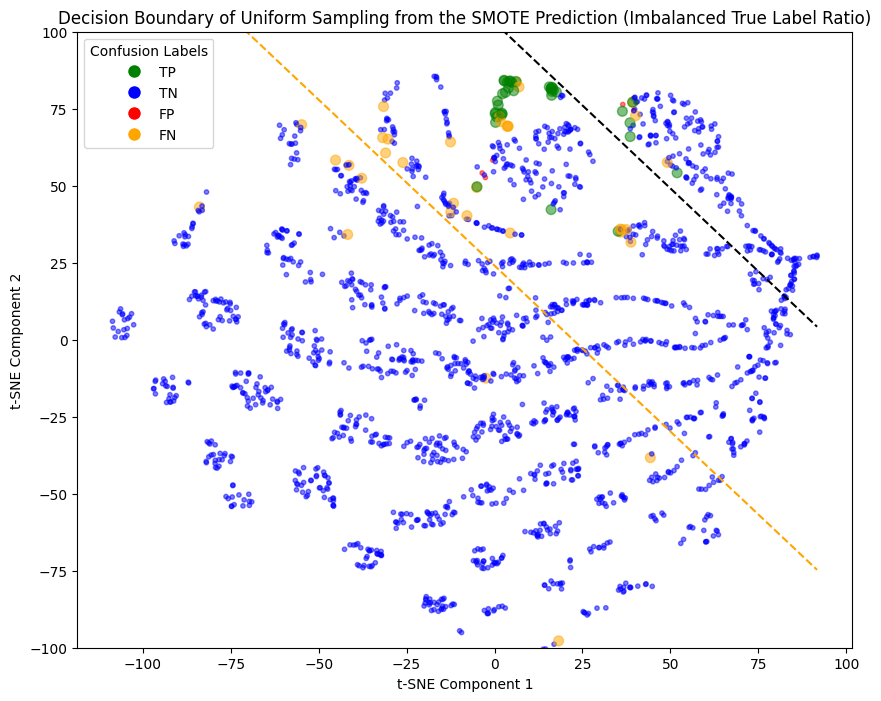

In [10]:
# Plot the decision boundary as a line, choose the 50-50 case
plt.figure(figsize=(10, 8))
a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
a.argsort()[:2]
x_values = X[a.argsort()[:2],0]
y_values = X[a.argsort()[:2],1]
# Calculate the slope
slope2 = (y_values[1] - y_values[0]) / (x_values[1] - x_values[0])

# Define the x-limits of the plot
x_min, x_max = X[:, 0].min(), X[:, 0].max()

# Calculate the y-values at the x-limits
y_min = slope2 * (x_min - x_values[0]) + y_values[0]
y_max = slope2 * (x_max - x_values[0]) + y_values[0]

# Node influence boundary
A_prime = A.copy()
# Parameters
alpha = 0.85  # random walk restart probability
I = np.eye(A_prime.shape[0])

# Initial label distribution (one-hot vectors for labeled nodes)
Y0 = np.zeros((A.shape[0], 2))
Y0[:, 1] = qb_pred['pred_scores'][sample_idx, 1]
Y0[:, 0] = 1 - Y0[:, 1]
# Label propagation
Y_prop = alpha * np.linalg.inv(I - (1 - alpha) * A_prime) @ Y0

b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])
x_values_inf = X[b.argsort()[0],0]
y_values_inf = X[b.argsort()[0],1]
# slope_inf = (y_values_inf[1] - y_values_inf[0]) / (x_values_inf[1] - x_values_inf[0])
y_min_inf = slope2 * (x_min - x_values_inf) + y_values_inf
y_max_inf = slope2 * (x_max - x_values_inf) + y_values_inf

# Plot the line
plt.figure(figsize=(10, 8))
plt.plot([x_min, x_max], [y_min, y_max], 'k--',label='Classification Boundary')
plt.plot([x_min, x_max], [y_min_inf, y_max_inf], '--',color='orange',label='Influence Boundary')
plt.scatter(coords[sample_idx, 0], coords[sample_idx, 1], c=colors[sample_idx], 
            label=conf_labels_uniform[sample_idx],
            s=sizes[sample_idx], marker='o',alpha=0.5)

# Create a legend for the labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
            for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Confusion Labels')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Decision Boundary of Uniform Sampling from the SMOTE Prediction (Imbalanced True Label Ratio)')
plt.ylim(-100, 100)
plt.show()

# Sample the index in a balanced way

In [11]:
np.random.seed(42)
# Sample 2000 nodes balancely to ensure the 50-50 ratio of the labels
sample_size = int(len(np.where(data['internal'].y==1)[0]) * 2)
sample_idx_0 = np.random.choice(np.where(data['internal'].y==0)[0],
                                int(sample_size/2), replace=False)
sample_idx_1 = np.random.choice(np.where(data['internal'].y==1)[0],
                                int(sample_size/2), replace=False)
sample_idx = np.concatenate([sample_idx_0, sample_idx_1])

X = coords[sample_idx]

# Calculate the label propagation
G = to_networkx(data, node_attrs=['x'])
# Get the adjacency matrix
A = nx.adjacency_matrix(G).todense()
A = A[sample_idx, :][:, sample_idx]

<Figure size 1000x800 with 0 Axes>

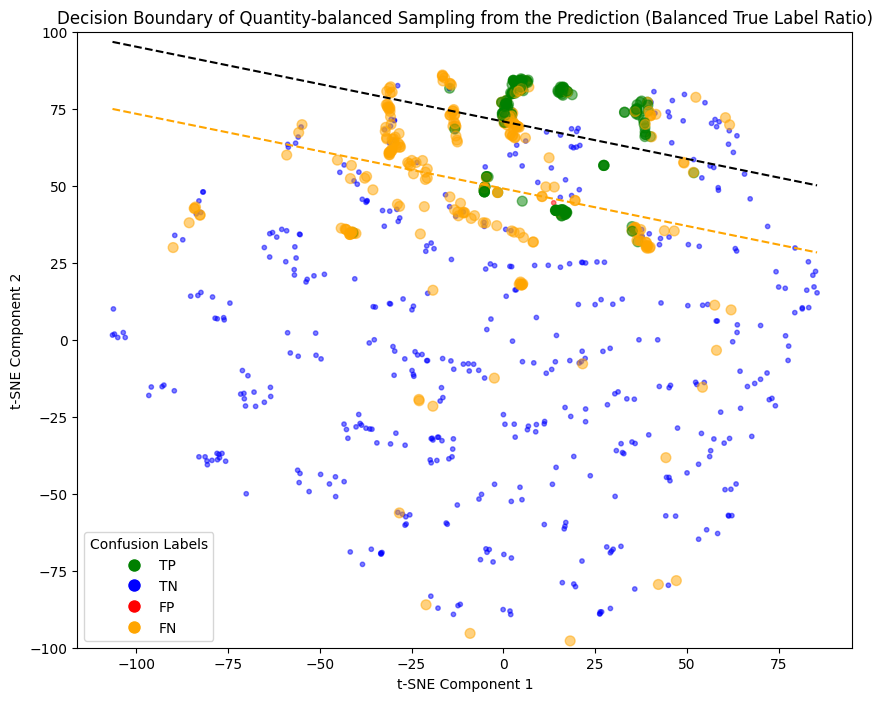

In [16]:
# Plot the decision boundary as a line, choose the 50-50 case
plt.figure(figsize=(10, 8))
a = np.abs(1 - uniform_pred['pred_scores'][sample_idx,1]/uniform_pred['pred_scores'][sample_idx,0])
x_values = X[a.argsort()[:2],0]
y_values = X[a.argsort()[:2],1]

# Calculate the slope
slope = slope1.copy() #(y_values[1] - y_values[0]) / (x_values[1] - x_values[0])

# Define the x-limits of the plot
x_min, x_max = X[:, 0].min(), X[:, 0].max()

# Calculate the y-values at the x-limits
y_min = slope * (x_min - x_values[0]) + y_values[0]
y_max = slope * (x_max - x_values[0]) + y_values[0]

# Node influence boundary
A_prime = A.copy()
# Parameters
alpha = 0.85  # random walk restart probability
I = np.eye(A_prime.shape[0])

# Initial label distribution (one-hot vectors for labeled nodes)
Y0 = np.zeros((A.shape[0], 2))
Y0[:, 1] = uniform_pred['pred_scores'][sample_idx, 1]
Y0[:, 0] = 1 - Y0[:, 1]
# Label propagation
Y_prop = alpha * np.linalg.inv(I - (1 - alpha) * A_prime) @ Y0

b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])
x_values_inf = X[b.argsort()[0],0]
y_values_inf = X[b.argsort()[0],1]
# slope_inf = (y_values_inf[1] - y_values_inf[0]) / (x_values_inf[1] - x_values_inf[0])
y_min_inf = slope * (x_min - x_values_inf) + y_values_inf
y_max_inf = slope * (x_max - x_values_inf) + y_values_inf

plt.figure(figsize=(10, 8))
# Plot the line for the decision boundary
plt.plot([x_min, x_max], [y_min, y_max], 'k--',label='Classification Boundary')
plt.plot([x_min, x_max], [y_min_inf, y_max_inf], '--',color='orange',label='Influence Boundary')

plt.scatter(coords[sample_idx, 0], coords[sample_idx, 1], c=colors[sample_idx], 
            label=conf_labels_uniform[sample_idx],
            s=sizes[sample_idx], marker='o',
            alpha=0.5)

# Create a legend for the labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
            for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Confusion Labels')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Decision Boundary of Quantity-balanced Sampling from the Prediction (Balanced True Label Ratio)')
plt.ylim(-100, 100)
plt.show()

/tmp/ipykernel_400258/3795855938.py:3: RuntimeWarning: divide by zero encountered in divide
  a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
/tmp/ipykernel_400258/3795855938.py:3: RuntimeWarning: overflow encountered in divide
  a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
/tmp/ipykernel_400258/3795855938.py:30: RuntimeWarning: divide by zero encountered in divide
  b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])


<Figure size 1000x800 with 0 Axes>

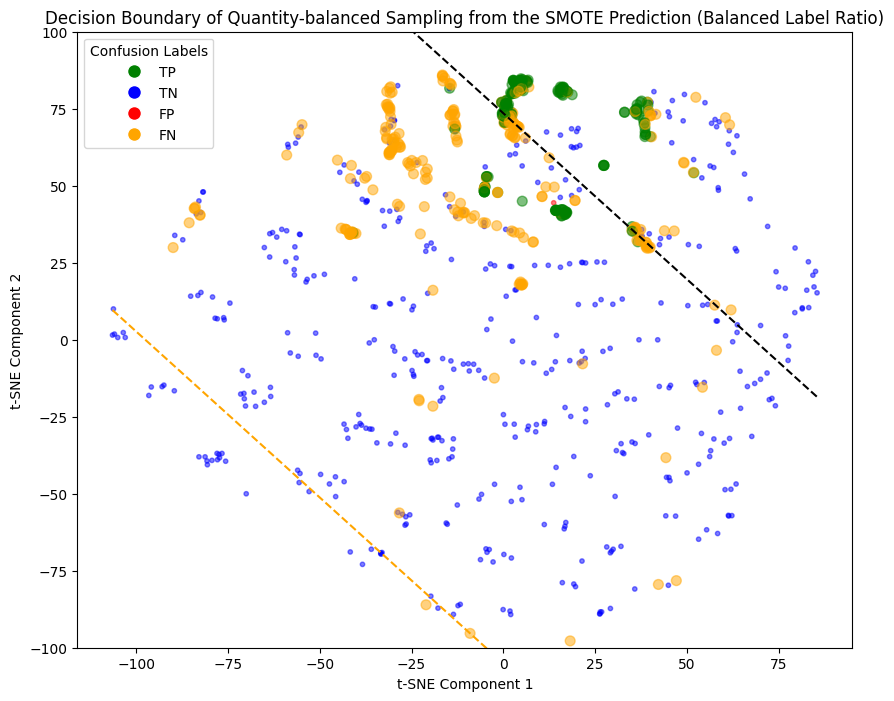

In [17]:
# Plot the decision boundary as a line, choose the 50-50 case
plt.figure(figsize=(10, 8))
a = np.abs(1 - qb_pred['pred_scores'][sample_idx,1]/qb_pred['pred_scores'][sample_idx,0])
a.argsort()[:2]
x_values = X[a.argsort()[:2],0]
y_values = X[a.argsort()[:2],1]
# Calculate the slope
slope = slope2 #(y_values[1] - y_values[0]) / (x_values[1] - x_values[0])

# Define the x-limits of the plot
x_min, x_max = X[:, 0].min(), X[:, 0].max()

# Calculate the y-values at the x-limits
y_min = slope * (x_min - x_values[0]) + y_values[0]
y_max = slope * (x_max - x_values[0]) + y_values[0]

# Node influence boundary
A_prime = A.copy()
# Parameters
alpha = 0.85  # random walk restart probability
I = np.eye(A_prime.shape[0])

# Initial label distribution (one-hot vectors for labeled nodes)
Y0 = np.zeros((A.shape[0], 2))
Y0[:, 1] = qb_pred['pred_scores'][sample_idx, 1]
Y0[:, 0] = 1 - Y0[:, 1]
# Label propagation
Y_prop = alpha * np.linalg.inv(I - (1 - alpha) * A_prime) @ Y0

b = np.abs(1 - Y_prop[:,1]/Y_prop[:,0])
x_values_inf = X[b.argsort()[0],0]
y_values_inf = X[b.argsort()[0],1]
# slope_inf = (y_values_inf[1] - y_values_inf[0]) / (x_values_inf[1] - x_values_inf[0])
y_min_inf = slope * (x_min - x_values_inf) + y_values_inf
y_max_inf = slope * (x_max - x_values_inf) + y_values_inf

# Plot the line
plt.figure(figsize=(10, 8))
plt.plot([x_min, x_max], [y_min, y_max], 'k--',label='Classification Boundary')
plt.plot([x_min, x_max], [y_min_inf, y_max_inf], '--',color='orange',label='Influence Boundary')
plt.scatter(coords[sample_idx, 0], coords[sample_idx, 1], c=colors[sample_idx], 
            label=conf_labels_uniform[sample_idx],
            s=sizes[sample_idx], marker='o',alpha=0.5)

# Create a legend for the labels
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) 
            for color in color_map.values()]
plt.legend(handles, color_map.keys(), title='Confusion Labels')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Decision Boundary of Quantity-balanced Sampling from the SMOTE Prediction (Balanced Label Ratio)')
plt.ylim(-100, 100)
plt.show()